In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
import os
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import tensorflow as tf
from tensorflow import *
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense , Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
print(tf.__version__)

2.1.0


In [55]:
train=pd.read_csv(r'C:\Users\HP\AppData\Local\Programs\Python\Python35\train\train.csv',low_memory=False)
test=pd.read_csv(r'C:\Users\HP\AppData\Local\Programs\Python\Python35\test\test.csv',low_memory=False)
resource=pd.read_csv(r'C:\Users\HP\AppData\Local\Programs\Python\Python35\resources\resources.csv',low_memory=False)

**DATA ANALYSIS**

In [18]:
train.head(),train.isnull().sum()

(        id                        teacher_id teacher_prefix school_state  \
 0  p036502  484aaf11257089a66cfedc9461c6bd0a            Ms.           NV   
 1  p039565  df72a3ba8089423fa8a94be88060f6ed           Mrs.           GA   
 2  p233823  a9b876a9252e08a55e3d894150f75ba3            Ms.           UT   
 3  p185307  525fdbb6ec7f538a48beebaa0a51b24f            Mr.           NC   
 4  p013780  a63b5547a7239eae4c1872670848e61a            Mr.           CA   
 
   project_submitted_datetime project_grade_category  \
 0        2016-11-18 14:45:59          Grades PreK-2   
 1        2017-04-26 15:57:28             Grades 3-5   
 2        2017-01-01 22:57:44             Grades 3-5   
 3        2016-08-12 15:42:11             Grades 3-5   
 4        2016-08-06 09:09:11             Grades 6-8   
 
             project_subject_categories  \
 0                  Literacy & Language   
 1    Music & The Arts, Health & Sports   
 2  Math & Science, Literacy & Language   
 3                      He

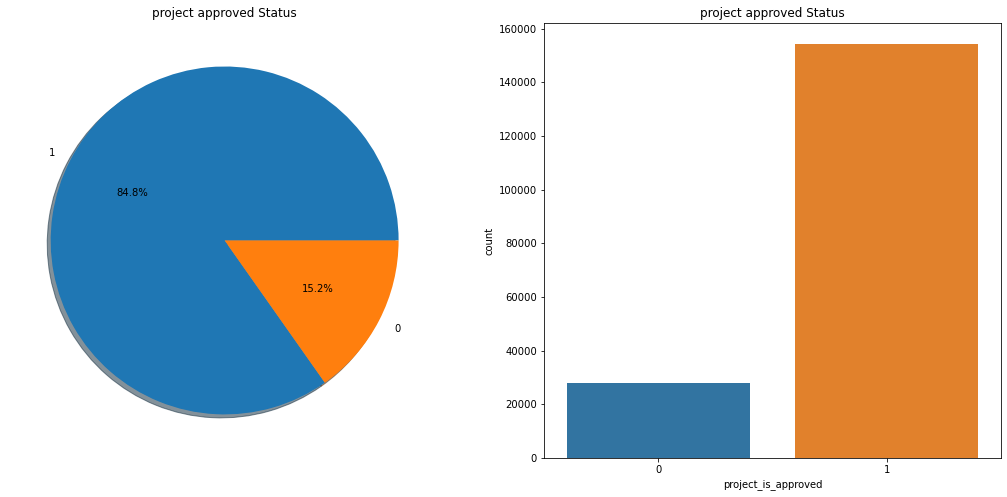

In [19]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
train['project_is_approved'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('project approved Status')
ax[0].set_ylabel('')

sns.countplot('project_is_approved', data=train, ax=ax[1])
ax[1].set_title('project approved Status')
plt.show()

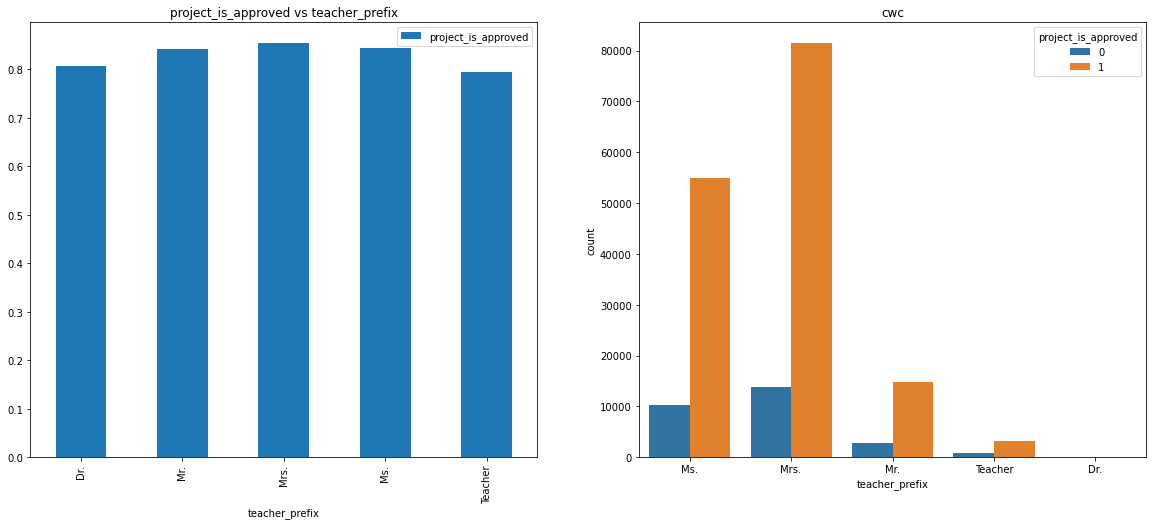

In [20]:
#teacher prefix
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

f, ax = plt.subplots(1, 2, figsize=(20,8))
train[['project_is_approved', 'teacher_prefix']].groupby(['teacher_prefix']).mean().plot.bar(ax=ax[0])
ax[0].set_title('project_is_approved vs teacher_prefix')
sns.countplot('teacher_prefix', hue='project_is_approved', data=train, ax=ax[1])
ax[1].set_title('cwc')
plt.show()

In [21]:
train.groupby(['project_is_approved', 'teacher_prefix'])['teacher_prefix'].count()

project_is_approved  teacher_prefix
0                    Dr.                   5
                     Mr.                2791
                     Mrs.              13921
                     Ms.               10212
                     Teacher             805
1                    Dr.                  21
                     Mr.               14876
                     Mrs.              81484
                     Ms.               54854
                     Teacher            3107
Name: teacher_prefix, dtype: int64

In [22]:
train['Initial'] = 0

train.loc[train['teacher_prefix'] == 'Dr.' , 'Initial'] = 0
train.loc[train['teacher_prefix'] == 'Mr.' , 'Initial'] = 1
train.loc[train['teacher_prefix'] == 'Mrs.' , 'Initial'] = 2
train.loc[train['teacher_prefix'] == 'Ms.' , 'Initial'] = 3
train.loc[train['teacher_prefix'] == 'Teacher' , 'Initial'] = 4

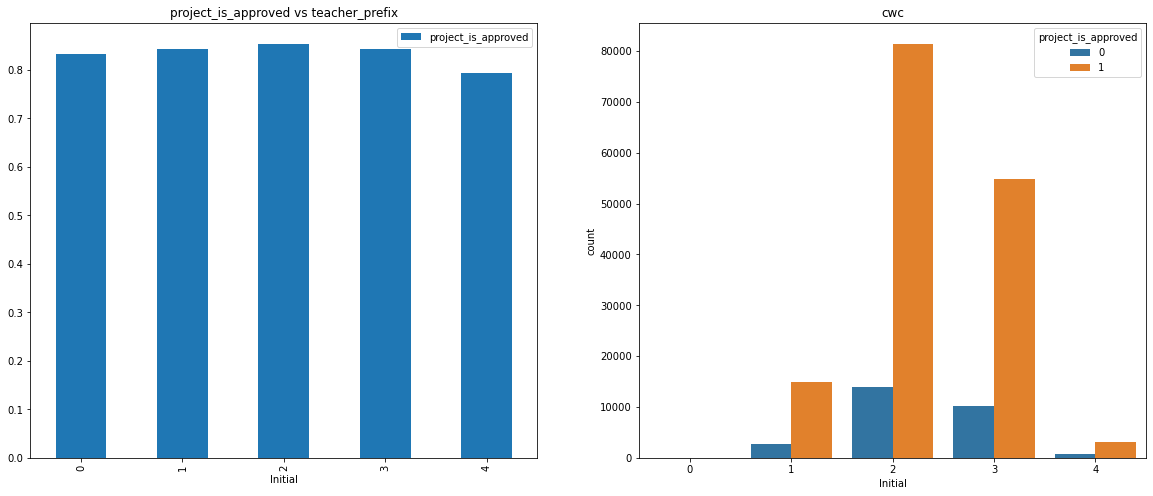

In [23]:
#cwc
f, ax = plt.subplots(1, 2, figsize=(20,8))
train[['project_is_approved', 'Initial']].groupby(['Initial']).mean().plot.bar(ax=ax[0])
ax[0].set_title('project_is_approved vs teacher_prefix')
sns.countplot('Initial', hue='project_is_approved', data=train, ax=ax[1])
ax[1].set_title('cwc')
plt.show()

In [24]:
train.groupby(['project_is_approved', 'project_grade_category'])['project_grade_category'].count()

project_is_approved  project_grade_category
0                    Grades 3-5                 9007
                     Grades 6-8                 4414
                     Grades 9-12                3017
                     Grades PreK-2             11296
1                    Grades 3-5                52675
                     Grades 6-8                23783
                     Grades 9-12               15294
                     Grades PreK-2             62594
Name: project_grade_category, dtype: int64

In [25]:
train['GRADE_CATEGORY'] = 0

train.loc[train['project_grade_category'] == 'Grades 3-5' , 'GRADE_CATEGORY'] = 0
train.loc[train['project_grade_category'] == 'Grades 6-8' , 'GRADE_CATEGORY'] = 1
train.loc[train['project_grade_category'] == 'Grades 9-12' , 'GRADE_CATEGORY'] = 2
train.loc[train['project_grade_category'] == 'Grades PreK-2' , 'GRADE_CATEGORY'] = 3

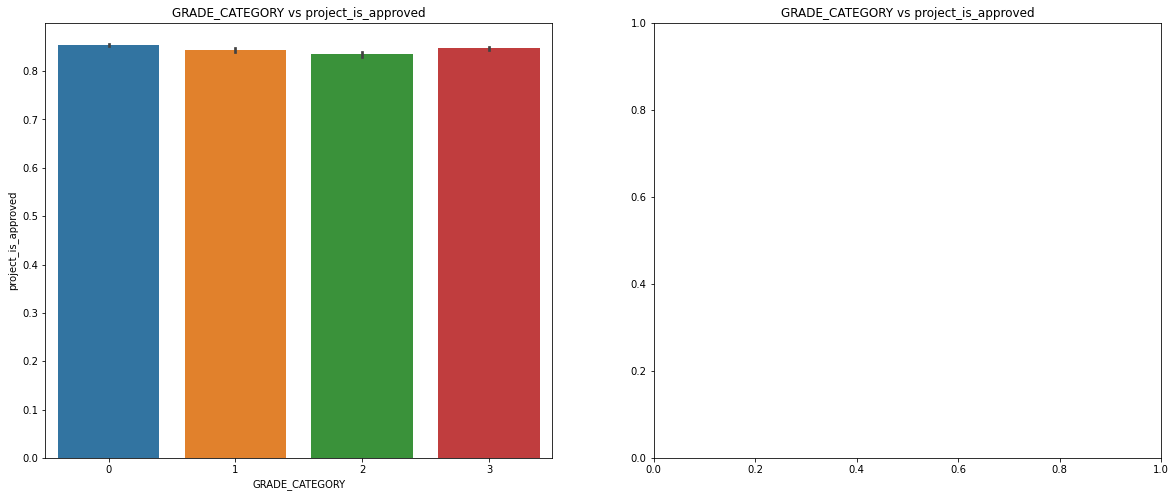

In [26]:
#grade category
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

f, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.barplot('GRADE_CATEGORY', 'project_is_approved', data=train, ax=ax[0])
ax[0].set_title('GRADE_CATEGORY vs project_is_approved')
sns.factorplot('GRADE_CATEGORY', 'project_is_approved', data=train, ax=ax[1])
ax[1].set_title('GRADE_CATEGORY vs project_is_approved')
plt.close(2)
plt.show()

**DATA PREPROCESSING**

In [3]:
train_x=train.drop(['project_essay_1','project_essay_2','project_essay_3','project_essay_4','project_resource_summary','teacher_prefix'],axis=1)
df=train_x
df

,id,teacher_id,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,teacher_number_of_previously_posted_projects,project_is_approved
0,p036502,484aaf11257089a66cfedc9461c6bd0a,NV,2016-11-18 14:45:59,Grades PreK-2,Literacy & Language,Literacy,Super Sight Word Centers,26,1
1,p039565,df72a3ba8089423fa8a94be88060f6ed,GA,2017-04-26 15:57:28,Grades 3-5,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",Keep Calm and Dance On,1,0
2,p233823,a9b876a9252e08a55e3d894150f75ba3,UT,2017-01-01 22:57:44,Grades 3-5,"Math & Science, Literacy & Language","Applied Sciences, Literature & Writing",Lets 3Doodle to Learn,5,1
3,p185307,525fdbb6ec7f538a48beebaa0a51b24f,NC,2016-08-12 15:42:11,Grades 3-5,Health & Sports,Health & Wellness,"\""Kid Inspired\"" Equipment to Increase Activit...",16,0
4,p013780,a63b5547a7239eae4c1872670848e61a,CA,2016-08-06 09:09:11,Grades 6-8,Health & Sports,Health & Wellness,We need clean water for our culinary arts class!,42,1
...,...,...,...,...,...,...,...,...,...,...
182075,p014188,dd05465e8daad481c9be9e61e147c9cd,NM,2016-10-07 16:13:32,Grades 6-8,Math & Science,Mathematics,Math is Fun!!,1,1
182076,p116452,40762708f7589d161ae883dede98a6a1,AZ,2017-03-11 23:58:31,Grades 9-12,Music & The Arts,Performing Arts,"\""Sew\"" you think you can design costumes!",0,1
182077,p074761,3429d29ecba4a37ac5bd69ded4aab341,AZ,2017-02-09 15:42:43,Grades 6-8,Math & Science,"Applied Sciences, Environmental Science",Sustainable Classroom,48,0
182078,p136737,497ba7027394d6490d2d2b34af2db5fd,FL,2016-12-28 14:20:07,Grades PreK-2,Literacy & Language,Literacy,Can I go to the library?,29,1


In [4]:
X = df.iloc[:, :-1].values
Y = df.iloc[:, -1].values
X,Y

(array([['p036502', '484aaf11257089a66cfedc9461c6bd0a', 'NV', ...,
         'Literacy', 'Super Sight Word Centers', 26],
        ['p039565', 'df72a3ba8089423fa8a94be88060f6ed', 'GA', ...,
         'Performing Arts, Team Sports', 'Keep Calm and Dance On', 1],
        ['p233823', 'a9b876a9252e08a55e3d894150f75ba3', 'UT', ...,
         'Applied Sciences, Literature & Writing',
         'Lets 3Doodle to Learn', 5],
        ...,
        ['p074761', '3429d29ecba4a37ac5bd69ded4aab341', 'AZ', ...,
         'Applied Sciences, Environmental Science',
         'Sustainable Classroom', 48],
        ['p136737', '497ba7027394d6490d2d2b34af2db5fd', 'FL', ...,
         'Literacy', 'Can I go to the library?', 29],
        ['p190772', '337bc63eccf6f6ee26e727a1f18b80f4', 'TX', ...,
         'Literacy', 'Reader Leaders!', 1]], dtype=object),
 array([1, 0, 1, ..., 0, 1, 1], dtype=int64))

In [5]:
labelencoder_X = LabelEncoder()
X[:,0] = labelencoder_X.fit_transform(X[:,0])
X[:,1] = labelencoder_X.fit_transform(X[:,1])
X[:,2] = labelencoder_X.fit_transform(X[:,2])
X[:,3] = labelencoder_X.fit_transform(X[:,3])
X[:,4] = labelencoder_X.fit_transform(X[:,4])
X[:,5] = labelencoder_X.fit_transform(X[:,5])
X[:,6] = labelencoder_X.fit_transform(X[:,6])
X[:,7] = labelencoder_X.fit_transform(X[:,7])
X[:,8] = labelencoder_X.fit_transform(X[:,8])
print(X)
tf.feature_column.categorical_column_with_vocabulary_list( 
    key='partial_funding_indicator', vocabulary_list=['True', 'False'],
    dtype=tf.string, num_oov_buckets=None)

array([[25578, 29315, 33, ..., 321, 133693, 26],
       [27694, 91061, 10, ..., 392, 75471, 1],
       [163739, 69247, 44, ..., 17, 85451, 5],
       ...,
       [52335, 21017, 3, ..., 8, 135142, 48],
       [95729, 29824, 9, ..., 321, 22344, 29],
       [133592, 20745, 43, ..., 321, 113747, 1]], dtype=object)


VocabularyListCategoricalColumn(key='partial_funding_indicator', vocabulary_list=('True', 'False'), dtype=tf.string, default_value=-1, num_oov_buckets=None)

In [6]:
labelencoder_Y = LabelEncoder()
Y= labelencoder_Y.fit_transform(Y)
print(Y)
def my_func(arg):
  arg = tf.convert_to_tensor(arg, dtype=tf.float32)
  return arg

array([1, 0, 1, ..., 0, 1, 1], dtype=int64)


In [7]:
tx=my_func(X)
fx=my_func(Y)

In [8]:
model=Sequential()

model.add(Dense(10,activation='relu'))

model.add(Dense(10,activation='relu'))
model.add(Dense(1))

model.add(Flatten())

In [9]:
model.compile(optimizer='adam',loss='mean_squared_error')
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [56]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

early=EarlyStopping(patience=3)
history=model.fit(tx , fx, epochs=50,callbacks=[early],batch_size=1024)

Train on 182080 samples
Epoch 1/50
182080/182080 [==============================] - 0s 3us/sample - loss: 484.5433
Epoch 2/50
182080/182080 [==============================] - 0s 2us/sample - loss: 8.3006
Epoch 3/50
182080/182080 [==============================] - 0s 2us/sample - loss: 214.5217
Epoch 4/50
182080/182080 [==============================] - 0s 2us/sample - loss: 294.5965
Epoch 5/50
182080/182080 [==============================] - 0s 2us/sample - loss: 500.7846
Epoch 6/50
182080/182080 [==============================] - 0s 2us/sample - loss: 5.9520
Epoch 7/50
182080/182080 [==============================] - 0s 2us/sample - loss: 584.8636
Epoch 8/50
182080/182080 [==============================] - 0s 2us/sample - loss: 5.9577
Epoch 9/50
182080/182080 [==============================] - 0s 2us/sample - loss: 15.0387
Epoch 10/50
182080/182080 [==============================] - 0s 2us/sample - loss: 463.8243
Epoch 11/50
182080/182080 [==============================] - 0s 2us/samp

In [46]:
test_x=test.drop(['project_essay_1','project_essay_2','project_essay_3','project_essay_4','project_resource_summary','teacher_prefix'],axis=1)
df=test_x
df
X2=df.values
X2

array([['p233245', '5724a0c3ce11008366fff36dab4b943c', 'CA', ...,
        'Visual Arts', 'Art Will Make You Happy!', 2],
       ['p096795', '445619941dc7cbe81c7be109dc61a56a', 'SC', ...,
        'Literature & Writing, Mathematics', 'Keeping up with the TIMEs',
        1],
       ['p236235', 'e92a4902b1611a189643d6f12c51e6a0', 'SC', ...,
        'Applied Sciences, Mathematics',
        'Building Bridges to Problem Solving', 0],
       ...,
       ['p210728', '692376a473aaf753890e329081b5787c', 'CA', ...,
        'Literacy, Literature & Writing', 'Everyday Authors Among Us', 4],
       ['p060531', '0fcaec76e9ea1730e81f2ca8eae5891b', 'OR', ...,
        'Warmth, Care & Hunger', 'Coat Lockers for Our Classroom!', 9],
       ['p087783', 'd3fd1b7b0efff1eddbd3fbfe4c00711e', 'IN', ...,
        'Literacy, Mathematics', 'A Coffee Shop Classroom', 0]],
      dtype=object)

In [47]:
labelencoder_X2 = LabelEncoder()
X2[:,0] = labelencoder_X2.fit_transform(X2[:,0])
X2[:,1] = labelencoder_X2.fit_transform(X2[:,1])
X2[:,2] = labelencoder_X2.fit_transform(X2[:,2])
X2[:,3] = labelencoder_X2.fit_transform(X2[:,3])
X2[:,4] = labelencoder_X2.fit_transform(X2[:,4])
X2[:,5] = labelencoder_X2.fit_transform(X2[:,5])
X2[:,6] = labelencoder_X2.fit_transform(X2[:,6])
X2[:,7] = labelencoder_X2.fit_transform(X2[:,7])
X2[:,8] = labelencoder_X2.fit_transform(X2[:,8])
print(X2)
tf.feature_column.categorical_column_with_vocabulary_list( 
    key='partial_funding_indicator', vocabulary_list=['True', 'False'],
    dtype=tf.string, num_oov_buckets=None)

array([[69904, 18923, 4, ..., 387, 4822, 2],
       [28960, 14777, 40, ..., 320, 33767, 1],
       [70818, 50545, 40, ..., 18, 8832, 0],
       ...,
       [63187, 22861, 4, ..., 307, 19224, 4],
       [18191, 3505, 37, ..., 389, 12859, 9],
       [26321, 46019, 15, ..., 308, 1241, 0]], dtype=object)


VocabularyListCategoricalColumn(key='partial_funding_indicator', vocabulary_list=('True', 'False'), dtype=tf.string, default_value=-1, num_oov_buckets=None)

In [48]:
cx=my_func(X2)
cx

<tf.Tensor: shape=(78035, 9), dtype=float32, numpy=
array([[6.9904e+04, 1.8923e+04, 4.0000e+00, ..., 3.8700e+02, 4.8220e+03,
        2.0000e+00],
       [2.8960e+04, 1.4777e+04, 4.0000e+01, ..., 3.2000e+02, 3.3767e+04,
        1.0000e+00],
       [7.0818e+04, 5.0545e+04, 4.0000e+01, ..., 1.8000e+01, 8.8320e+03,
        0.0000e+00],
       ...,
       [6.3187e+04, 2.2861e+04, 4.0000e+00, ..., 3.0700e+02, 1.9224e+04,
        4.0000e+00],
       [1.8191e+04, 3.5050e+03, 3.7000e+01, ..., 3.8900e+02, 1.2859e+04,
        9.0000e+00],
       [2.6321e+04, 4.6019e+04, 1.5000e+01, ..., 3.0800e+02, 1.2410e+03,
        0.0000e+00]], dtype=float32)>

**PREDICTION**

In [49]:
predict=model.predict(cx)
df3 = pd.DataFrame(data = predict)
df3

,0
0,0.591857
1,-0.341248
2,0.871154
3,0.623107
4,0.197326
...,...
78030,1.315490
78031,1.170959
78032,1.444396
78033,2.624084
